In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
list_id = []
list_latitude = []
list_longitude = []
list_elevation = []
list_state = []

with open('data/ghcnd-stations.txt', 'r') as f:
    for line in f:
        # split the spaces
        list_line = line.split(' ')
        # delete the empty characters
        list_line = [line for line in list_line if line != '']

        # mapping file has the following columns:
        # id, latitude, longitude, elevation, state, name, gsn flag, wmo id
        # let's say that we don't care about name, gsn flag and wmo id
        # so we just want to keep the first 5 fields
        # we keep the state just for US contries, for other countries we put the first
        # two letters of the id
        if list_line[0][:2] == 'US':
            list_line = list_line[:5]
            state = list_line[4]
        else:
            list_line = list_line[:4]
            state = list_line[0][:2]
        
        list_id.append(list_line[0])
        list_latitude.append(list_line[1])
        list_longitude.append(list_line[2])
        list_elevation.append(list_line[3])
        list_state.append(state)


mapping_df = pd.DataFrame({
    'id': list_id,
    'latitude': list_latitude,
    'longitude': list_longitude,
    'elevation': list_elevation,
    'state': list_state
})

mapping_df['latitude'] = mapping_df['latitude'].astype(float)
mapping_df['longitude'] = mapping_df['longitude'].astype(float)
mapping_df['elevation'] = mapping_df['elevation'].astype(float)

mapping_df = mapping_df.set_index('id')



In [3]:
files = os.listdir('data')
files = [f for f in files if (('.csv' in f) and ('.gz' not in f))]

In [4]:
def format_dataset(filename):
    
    print(f"Working on file {filename}")

    dataset = pd.read_csv(filename, header=None, dtype={1: str, 7: str})

    dataset.columns = ['id', 'date', 'element', 'value', 'm_flag', 'q_flag', 's_flag', 'obs_time']
    dataset = dataset.loc[dataset['q_flag'].isna()]
    dataset = dataset.loc[dataset['element'] == 'PRCP']
    dataset = dataset.loc[dataset['m_flag'] != 'T']

    dataset['datetime'] = pd.to_datetime(dataset['date'], format='%Y%m%d')

    dataset = dataset.set_index(['datetime', 'id', 'element'])

    dataset = dataset.sort_index()

    # just keep US data
    us_ids = [a for a in list(dataset.index.get_level_values('id').unique()) if 'US' in a]
    dataset = dataset.loc[dataset.index.get_level_values('id').isin(us_ids)]

    return dataset

In [5]:
historical_precipitations = []

for file in files:
    precipitation = format_dataset('data/' + file)

    historical_precipitations.append(precipitation)

historical_precipitations = pd.concat(historical_precipitations)


Working on file data/2020.csv
Working on file data/2021.csv
Working on file data/2022.csv
Working on file data/2023.csv
Working on file data/2024.csv


In [6]:
historical_precipitations = historical_precipitations.droplevel(2)

In [7]:
historical_precipitations['m_flag'] = historical_precipitations['m_flag'].fillna('no_info')

In [8]:
historical_precipitations = historical_precipitations.set_index('m_flag', append=True)

In [9]:
historical_precipitations = historical_precipitations[['value']]

In [10]:
historical_precipitations = historical_precipitations['value'].unstack()

In [11]:
historical_precipitations = historical_precipitations.join(mapping_df)

In [12]:
historical_precipitations

D  no_info  latitude  longitude  elevation state
datetime   id                                                            
2020-01-01 US10adam002 NaN      0.0   40.5093   -98.5493      601.1    NE
           US10adam004 NaN      0.0   40.4798   -98.4026      570.0    NE
           US10adam008 NaN      0.0   40.4953   -98.2973      566.9    NE
           US10adam010 NaN      0.0   40.5532   -98.6297      622.1    NE
           US10adam022 NaN      0.0   40.5936   -98.4299      597.1    NE
...                     ..      ...       ...        ...        ...   ...
2024-06-05 USW00014838 NaN     20.0   46.5458   -87.3794      202.7    MI
           USW00014924 NaN      8.0   48.9711   -97.2417      240.8    ND
           USW00014930 NaN      0.0   41.4500   -95.0667      353.0    IA
           USW00024020 NaN     18.0   40.5233  -101.0344      928.1    NE
           USW00025322 NaN    198.0   58.4111  -135.7089       12.2    AK

[32454116 rows x 6 columns]

In [13]:
historical_precipitations.to_parquet('historical_precipitations.parquet')

<Axes: xlabel='datetime'>

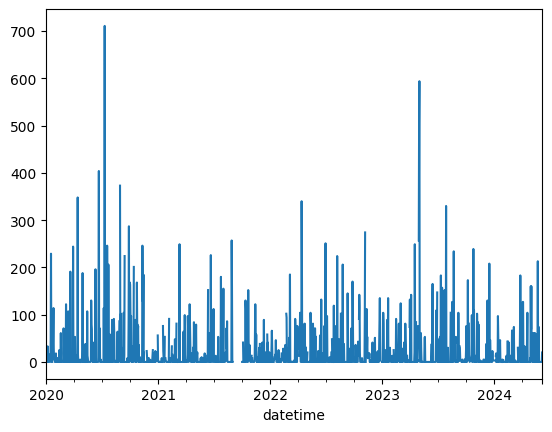

In [27]:
historical_precipitations['no_info'].unstack()['USW00014838'].resample('D').asfreq().plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

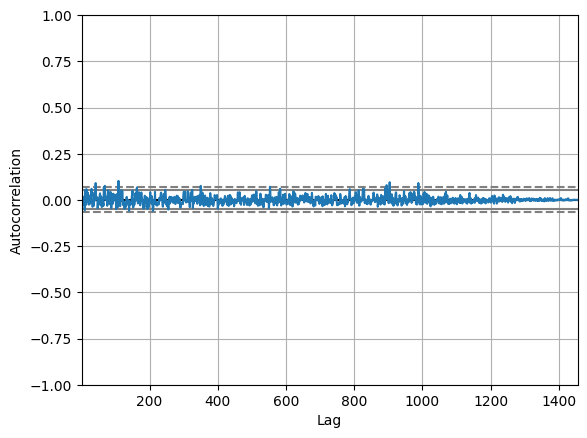

In [22]:
pd.plotting.autocorrelation_plot(historical_precipitations['no_info'].unstack()['USW00014838'].resample('D').asfreq().dropna())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

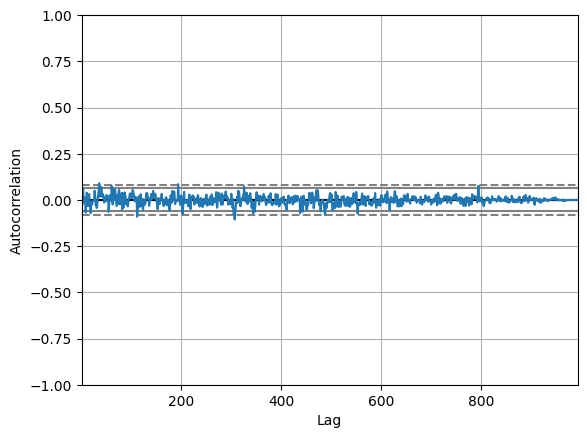

In [23]:
pd.plotting.autocorrelation_plot(historical_precipitations['no_info'].unstack()['USW00014838'].resample('D').asfreq().diff(365).dropna())

In [24]:
adfuller(historical_precipitations['no_info'].unstack()['USW00014838'].resample('D').asfreq().dropna())

(-24.962109511001415,
 0.0,
 1,
 1453,
 {'1%': -3.434858527373781,
  '5%': -2.8635312133080046,
  '10%': -2.567830105465636},
 15446.456888401151)

In [25]:
adfuller(historical_precipitations['no_info'].unstack()['USW00014838'].resample('D').asfreq().diff(365).dropna())

(-21.26359257983748,
 0.0,
 1,
 991,
 {'1%': -3.4369658620871286,
  '5%': -2.8644609013346485,
  '10%': -2.56832523159495},
 10995.314679808818)